# 🔺 Construcción de la Triangulación Causal
Este notebook toma un árbol de Galton-Watson con espina y genera la triangulación causal correspondiente en el cilindro \( S \times [n, n+1] \).

Nodo raíz: (0, 0)
Tamaño cluster de la raíz: 3
Tamaño cluster máximo: 55


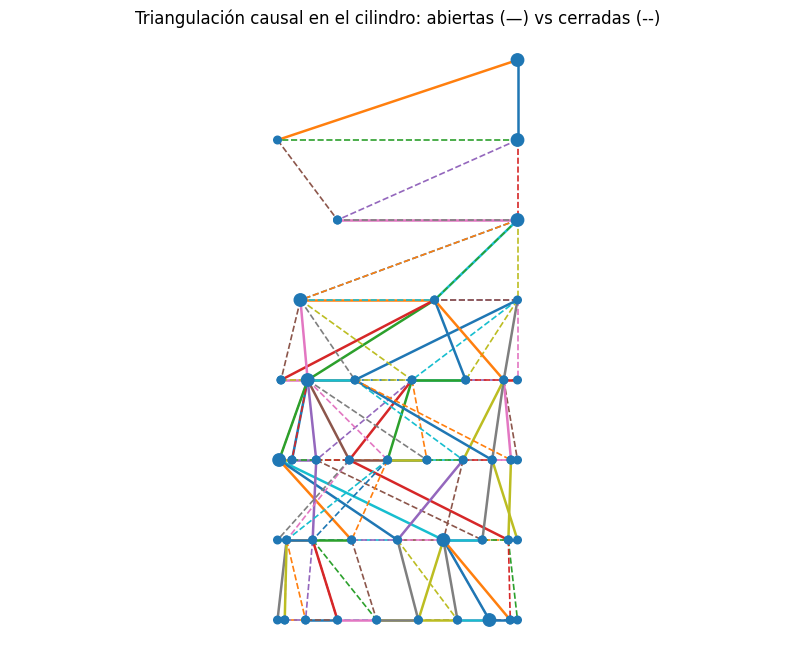

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque

# =========================================================
# 1) Muestreos: pk (geométrica base) y rho (sesgada por tamaño)
# =========================================================

def sample_pk(rng):
    """
    pk = 1 / 2^(k+1), k >= 0  (geométrica en 'fracasos antes del primer éxito' con p=1/2)
    NumPy: Geometric(p) retorna {1,2,...}; restamos 1 para obtener {0,1,2,...}
    """
    return rng.geometric(0.5) - 1

def sample_rho(rng):
    """
    rho_k = k / 2^(k+1), k >= 1
    Muestreo por inversa de la CDF cerrada: F(n) = 1 - (n+2) / 2^(n+1)
    """
    u = rng.random()
    n = 1
    while True:
        if u <= 1 - (n + 2) / (2 ** (n + 1)):
            return n
        n += 1

# =========================================================
# 2) Generación de capas (niveles) con registro exacto de hijos por padre (splits)
# =========================================================

def generate_layers_with_splits(n_layers=6, seed=None):
    """
    Devuelve:
      - layers: lista de niveles; cada nivel es una lista de IDs de nodos (enteros globales).
      - spine_ids: lista con el ID del nodo spine por nivel (mismo largo que layers).
      - splits: para cada strip i->i+1, una lista [k_1, ..., k_m] con el # de hijos de cada padre del nivel i.
    """
    rng = np.random.default_rng(seed)

    layers = [[0]]                # nivel 0: raíz
    spine_id = 0                  # la raíz es el primer spine
    spine_ids = [spine_id]        # spine por nivel
    splits = []                   # por strip i->i+1
    next_node_id = 1

    for _ in range(n_layers):
        current_level = layers[-1]
        if len(current_level) == 0:
            break

        new_level = []
        split_this_strip = []
        spine_child_candidates = []

        for parent in current_level:
            if parent == spine_id:
                k = sample_rho(rng)       # SOLO spine usa rho
            else:
                k = sample_pk(rng)        # no-spine usa pk
            split_this_strip.append(k)

            if k > 0:
                children = list(range(next_node_id, next_node_id + k))
                next_node_id += k
                new_level.extend(children)

                if parent == spine_id:
                    # elegir candidato a nuevo spine uniformemente entre sus hijos
                    spine_child_candidates.append(children[rng.integers(0, k)])
            else:
                # sin hijos
                pass

        splits.append(split_this_strip)

        # nuevo spine: si el spine tuvo hijos, debe existir candidato
        spine_id = spine_child_candidates[0] if len(spine_child_candidates) > 0 else -1
        spine_ids.append(spine_id)

        layers.append(new_level)
        if len(new_level) == 0:
            break

    return layers, spine_ids, splits

# =========================================================
# 3) Triangulación exacta por tiras (tiempo, auxiliares, espacio)
# =========================================================

def triangulate_layers_exact(layers, splits):
    """
    Construye la triangulación causal (solo estructura de aristas no dirigidas):
      - tiempo: cada padre (en nivel i) con TODOS sus hijos (en i+1)
      - auxiliares en i+1: último hijo de un padre con el primer hijo del siguiente padre con hijos (circular)
      - espacio: anillo en CADA nivel i (vecinos consecutivos y cierre circular)
    Nodos se representan como tuplas (nivel, id_global).
    Retorna:
      - edges_all: lista de aristas (a,b) con a<b (sin duplicados)
      - levels: lista de niveles, cada uno lista de ids globales (en orden)
      - root_node: (0, layers[0][0])
    """
    # nodos por nivel (en orden)
    levels = [list(lvl) for lvl in layers]

    time_edges = set()
    aux_edges = set()
    space_edges = set()

    # Espacio (anillo) en todos los niveles
    for i, lvl in enumerate(levels):
        m = len(lvl)
        if m >= 2:
            for j in range(m):
                a = (i, lvl[j])
                b = (i, lvl[(j+1) % m])  # cierre circular
                edge = tuple(sorted((a, b)))
                space_edges.add(edge)

    # Tiempo + auxiliares por strip
    for i in range(len(levels) - 1):
        parents = levels[i]
        children = levels[i+1]
        if len(parents) == 0 or len(children) == 0:
            continue

        k_list = splits[i] if i < len(splits) else [0] * len(parents)

        # Partición contigua exacta de children por padre usando k_list
        groups = []
        pos = 0
        for k in k_list:
            groups.append(children[pos:pos+k])
            pos += k

        # Aristas de tiempo: cada padre con todos sus hijos
        for j, parent in enumerate(parents):
            for c in groups[j]:
                a = (i, parent)
                b = (i+1, c)
                edge = tuple(sorted((a, b)))
                time_edges.add(edge)

        # Aristas auxiliares en el nivel superior (i+1):
        # conectar último hijo de cada padre con el primer hijo del siguiente padre con hijos (circular)
        m = len(parents)
        for j in range(m):
            if len(groups[j]) == 0:
                continue
            last_child = (i+1, groups[j][-1])
            # buscar siguiente padre con hijos (circular)
            s = (j + 1) % m
            while s != j and len(groups[s]) == 0:
                s = (s + 1) % m
            if s != j and len(groups[s]) > 0:
                first_child_next = (i+1, groups[s][0])
                edge = tuple(sorted((last_child, first_child_next)))
                aux_edges.add(edge)
            # si nadie más tiene hijos, no hay auxiliar para este j

    edges_all = sorted(list(time_edges | aux_edges | space_edges))
    root_node = (0, levels[0][0]) if len(levels[0]) > 0 else None
    return edges_all, levels, root_node

# =========================================================
# 4) Percolación en aristas y utilidades de cluster
# =========================================================

def percolate_edges(edges_all, p, seed=None):
    """
    Abre cada arista con prob. p. Devuelve lista de aristas abiertas y adjacencia abierta.
    """
    rng = np.random.default_rng(seed)
    open_edges = []
    open_adj = defaultdict(list)
    for a, b in edges_all:
        if rng.random() < p:
            open_edges.append((a, b))
            open_adj[a].append(b)
            open_adj[b].append(a)
    return open_edges, open_adj

def bfs_cluster(open_adj, start):
    """
    Cluster (conjunto de nodos) alcanzable desde 'start' usando solo aristas abiertas.
    Si start no tiene aristas abiertas, retorna {start}.
    """
    if start is None:
        return set()
    if start not in open_adj:
        return {start}
    visited = {start}
    q = deque([start])
    while q:
        u = q.popleft()
        for v in open_adj[u]:
            if v not in visited:
                visited.add(v)
                q.append(v)
    return visited

def all_open_components(open_adj):
    """
    Lista de componentes conexas por aristas abiertas (como conjuntos de nodos).
    """
    comps = []
    seen = set()
    for u in list(open_adj.keys()):
        if u in seen:
            continue
        comp = bfs_cluster(open_adj, u)
        comps.append(comp)
        seen |= comp
    return comps

# =========================================================
# 5) Dibujo en “cilindro”: círculos por nivel; aristas abiertas (—) y cerradas (--)
# =========================================================

def draw_cylinder_percolation(levels, edges_all, open_edges, node_marker=None):
    """
    Dibuja todos los niveles sobre circunferencias, apiladas verticalmente.
      - Aristas abiertas: línea continua
      - Aristas cerradas: línea punteada
    node_marker: dict opcional {(nivel, id_global): {'espina': True/False}}, para resaltar espina con tamaño
    """
    # Posiciones por nivel (en círculo)
    pos = {}
    y_gap = 2.0
    R = 3.0
    for d, lvl in enumerate(levels):
        m = max(len(lvl), 1)
        thetas = np.linspace(0, 2*np.pi, m, endpoint=False) if m > 1 else np.array([0.0])
        for j, gid in enumerate(lvl):
            x = R * np.cos(thetas[j])
            y = -d * y_gap
            pos[(d, gid)] = (x, y)

    open_set = set(tuple(sorted(e)) for e in open_edges)

    plt.figure(figsize=(10, 8))

    # Aristas: abiertas (—) y cerradas (--)
    for a, b in edges_all:
        x1, y1 = pos[a]; x2, y2 = pos[b]
        if tuple(sorted((a, b))) in open_set:
            plt.plot([x1, x2], [y1, y2], linestyle='-', linewidth=1.8)
        else:
            plt.plot([x1, x2], [y1, y2], linestyle='--', linewidth=1.2)

    # Nodos (opcional: resaltar espina con tamaño mayor)
    xs, ys, ss = [], [], []
    for d, lvl in enumerate(levels):
        for gid in lvl:
            x, y = pos[(d, gid)]
            xs.append(x); ys.append(y)
            if node_marker is not None and node_marker.get((d, gid), {}).get('espina', False):
                ss.append(80)
            else:
                ss.append(30)
    plt.scatter(xs, ys, s=ss, zorder=3)

    plt.title("Triangulación causal en el cilindro: abiertas (—) vs cerradas (--)")
    plt.axis('equal'); plt.axis('off')
    plt.show()

# =========================================================
# 6) Ejemplo de uso completo
# =========================================================

if __name__ == "__main__":
    # 1) Generar capas con seguimiento exacto de hijos por padre
    layers, spine_ids, splits = generate_layers_with_splits(n_layers=7, seed=None)

    # 2) Triangular exactamente (tiempo + auxiliares + espacio)
    edges_all, levels, root_node = triangulate_layers_exact(layers, splits)

    # 3) (Opcional) marcador de espina para dibujar nodos más grandes
    node_marker = {}
    for d, lvl in enumerate(levels):
        for gid in lvl:
            node_marker[(d, gid)] = {'espina': (gid == spine_ids[d])}

    # 4) Percolación con probabilidad p
    p = 0.48
    open_edges, open_adj = percolate_edges(edges_all, p, seed=None)

    # 5) Observables
    root_cluster = bfs_cluster(open_adj, root_node)
    comps = all_open_components(open_adj)
    size_root = len(root_cluster)
    size_max = max((len(c) for c in comps), default=1)

    print("Nodo raíz:", root_node)
    print("Tamaño cluster de la raíz:", size_root)
    print("Tamaño cluster máximo:", size_max)

    # 6) Dibujo del cilindro: línea continua (abierta) / punteada (cerrada)
    draw_cylinder_percolation(levels, edges_all, open_edges, node_marker=node_marker)

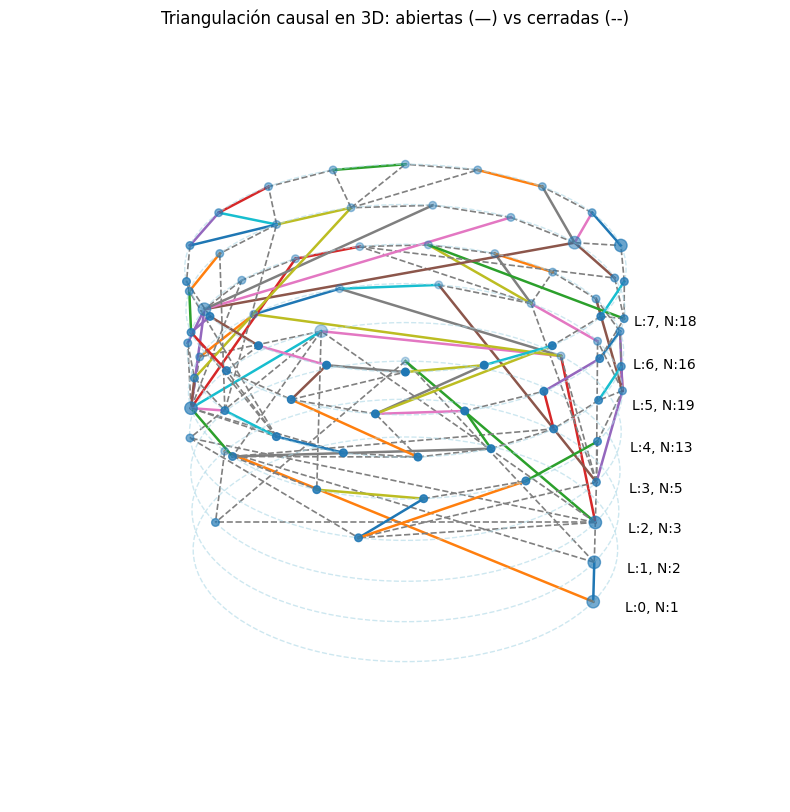


Node count per level:
Level 0: 1 nodes
Level 1: 2 nodes
Level 2: 3 nodes
Level 3: 5 nodes
Level 4: 13 nodes
Level 5: 19 nodes
Level 6: 16 nodes
Level 7: 18 nodes


In [24]:
from mpl_toolkits.mplot3d import Axes3D

def draw_cylinder_3d(levels, edges_all, open_edges, node_marker=None):
    """
    Dibuja la triangulación en 3D en un "cilindro", intentando minimizar cruces.
      - Nodos de cada nivel en un círculo 3D.
      - Aristas abiertas: línea continua
      - Aristas cerradas: línea punteada
    node_marker: dict opcional {(nivel, id_global): {'espina': True/False}}, para resaltar espina con tamaño
    """
    pos = {}
    z_gap = 2.0  # Gap vertical entre niveles (now along z-axis)
    R = 3.0      # Radio del cilindro

    # Calculate positions for each node
    for d, lvl in enumerate(levels):
        m = max(len(lvl), 1)
        # Distribute nodes evenly on a circle in the x-y plane
        thetas = np.linspace(0, 2 * np.pi, m, endpoint=False) if m > 1 else np.array([0.0])
        for j, gid in enumerate(lvl):
            x = R * np.cos(thetas[j])
            y = R * np.sin(thetas[j])
            z = d * z_gap  # Stack levels vertically along the positive z-axis
            pos[(d, gid)] = (x, y, z)

    open_set = set(tuple(sorted(e)) for e in open_edges)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Draw edges: open (—) and closed (--)
    for a, b in edges_all:
        x1, y1, z1 = pos[a]
        x2, y2, z2 = pos[b]
        if tuple(sorted((a, b))) in open_set:
            ax.plot([x1, x2], [y1, y2], [z1, z2], linestyle='-', linewidth=1.8)
        else:
            ax.plot([x1, x2], [y1, y2], [z1, z2], linestyle='--', linewidth=1.2, color='gray')


    # Draw nodes (optional: highlight spine with larger size)
    xs, ys, zs, ss = [], [], [], []
    for d, lvl in enumerate(levels):
        for gid in lvl:
            x, y, z = pos[(d, gid)]
            xs.append(x); ys.append(y); zs.append(z)
            if node_marker is not None and node_marker.get((d, gid), {}).get('espina', False):
                ss.append(80)
            else:
                ss.append(30)

    ax.scatter(xs, ys, zs, s=ss, zorder=3)

    # Draw circles for each level
    for d in range(len(levels)):
        z_level = d * z_gap
        theta = np.linspace(0, 2*np.pi, 100)
        x_circle = R * np.cos(theta)
        y_circle = R * np.sin(theta)
        z_circle = np.full_like(theta, z_level)
        ax.plot(x_circle, y_circle, z_circle, color='lightblue', linestyle='--', linewidth=1, alpha=0.6)


    # Label levels and add text for node counts
    for d, lvl in enumerate(levels):
        z_level = d * z_gap # Use z_level for text placement
        ax.text(R + 0.5, 0, z_level, f'L:{d}, N:{len(lvl)}', zorder=4) # Adjusted text label


    ax.set_title("Triangulación causal en 3D: abiertas (—) vs cerradas (--)")
    ax.set_xlabel('X')
    ax.set_ylabel('Y') # Y is now horizontal
    ax.set_zlabel('Z (Level)') # Z is now vertical
    ax.axis('off') # Hide axes for a cleaner look
    plt.show()

# --- Example of use ---
# Use the variables generated in the previous cell
draw_cylinder_3d(levels, edges_all, open_edges, node_marker=node_marker)

# Display node count per level
print("\nNode count per level:")
for i, level in enumerate(levels):
    print(f"Level {i}: {len(level)} nodes")